# Task 1: CNN on EuroSAT dataset for Image Classification

#### Name: Ankit Kumar Verma
#### R.No: 21CS60A04

### Setting Filepaths and Variables

In [104]:
dataset_filepath = '../Dataset/euroSAT_train_val_test.pkl'
batch_size = 64
num_epochs = 50
lr = 0.001
# Early stopping epoch value if validation doesnt improve
k = 7

### Importing required libraries

In [146]:
import pickle
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from pathlib import Path
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

#### Setting the random_seed to 04 (Roll Number: 21CS60A04)

In [106]:
# random seed initialized the random number generator of pytorch. 
# It ensures that same random number is generated for all the runs/executions
random_seed = int(4)
torch.manual_seed(random_seed)

#### Loading the Dataset

In [107]:
dataset_classes = ['AnnualCrop', 'Forest', 'HerbaceousVeg', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [108]:
with open(dataset_filepath, 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)

In [109]:
len_trainset = len(train_set)
len_valset = len(val_set)
len_testset = len(test_set)
print(f'Length of Training Set: {len_trainset}\nLength of Validation Set: {len_valset}\nLength of Test Set: {len_testset}')

Length of Training Set: 18792
Length of Validation Set: 2808
Length of Test Set: 5400


#### Extracting an instance from the dataset

In [112]:
img, label = train_set[0]
print(f'Image: {type(img)}')
print(img)
print(f'Label: {type(label)}')
print(f'{label} : {dataset_classes[label]}')

Image: <class 'numpy.ndarray'>
[[[0.41960785 0.4745098  0.42745098 ... 0.54509807 0.5372549  0.49411765]
  [0.43529412 0.4627451  0.40784314 ... 0.5568628  0.5372549  0.46666667]
  [0.44313726 0.44313726 0.38039216 ... 0.4627451  0.41568628 0.38039216]
  ...
  [0.5176471  0.5176471  0.49803922 ... 0.44705883 0.4509804  0.48235294]
  [0.5058824  0.5137255  0.53333336 ... 0.4862745  0.42352942 0.46666667]
  [0.48235294 0.4745098  0.4745098  ... 0.41568628 0.3764706  0.45882353]]

 [[0.47843137 0.45490196 0.38039216 ... 0.5294118  0.5176471  0.47058824]
  [0.47058824 0.45882353 0.38039216 ... 0.52156866 0.5137255  0.4745098 ]
  [0.4627451  0.45882353 0.3882353  ... 0.41568628 0.4        0.40784314]
  ...
  [0.50980395 0.5137255  0.5058824  ... 0.41568628 0.4117647  0.43137255]
  [0.49803922 0.5019608  0.5294118  ... 0.46666667 0.4        0.44313726]
  [0.45882353 0.4627451  0.47058824 ... 0.4117647  0.37254903 0.47058824]]

 [[0.49019608 0.47058824 0.39607844 ... 0.5254902  0.53333336 0.5

#### Converting train_dataset to Tensors

In [113]:
train_dataset = []
for itr in range(len_trainset):
    data = []
    img = torch.tensor(train_set[itr][0])
    lbl = train_set[itr][1]
    data.append(img)
    data.append(lbl)
    train_dataset.append(data)

#### Extracting an instance from train_dataset(Tensors)

In [114]:
img1, label1 = train_dataset[0]
img2, label2 = train_dataset[1]
print(f'Image1 Shape:\t{img1.shape}\nImage1 label:\t{dataset_classes[label1]}')
print(f'Image2 Shape:\t{img2.shape}\nImage2 label:\t{dataset_classes[label2]}')

Image1 Shape:	torch.Size([3, 64, 64])
Image1 label:	Residential
Image2 Shape:	torch.Size([3, 64, 64])
Image2 label:	Industrial


#### Converting val_set to Tensors

In [115]:
val_dataset = []
for itr in range(len_valset):
    data = []
    img = torch.tensor(val_set[itr][0])
    lbl = val_set[itr][1]
    data.append(img)
    data.append(lbl)
    val_dataset.append(data)

#### Converting test_set to Tensors

In [116]:
test_dataset = []
for itr in range(len_testset):
    data = []
    img = torch.tensor(test_set[itr][0])
    lbl = test_set[itr][1]
    data.append(img)
    data.append(lbl)
    test_dataset.append(data)

#### Creating the training and validation dataloaders

In [117]:
#### How to select batch_size
#### Start with 64
#### Keep doubling the batch size as you train. If the training time decreases, keep the higher batch size.
#### At some point the training time will start increasing, it happens because the amount of data that is put on RAM/GPU
#### for each batch of gradient descent may be using all the cpu/gpu cores that is available which would be taking longer
#### to compute rather than a smaller batch.
#### You might get out of memory error because the batch size if not fitting on the cpu/gpu

#### Rule of Thumb:
#### Double the batch size until the training time decreases
#### Half the batch size if you are getting out of memory error
#### Keep the batch_size of validation set double then that of training_set. This is because gradient descent is 
#### not calculated during validatio stage. Since, gradient descent is not calculated, only half of the memory
#### compared to the training is required.

In [118]:
train_dl = DataLoader(train_dataset, 
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)
val_dl = DataLoader(val_dataset, 
                  batch_size*2,
                  num_workers=4,
                  pin_memory=True) 

### Building Model for classification

In [119]:
# Generic Class to classify images
# Loss Function: cross_entropy
class ImageClassificationBase(nn.Module):
    # Training Step
    def training_step(self, batch):
        images, labels = batch
        res = self(images)
        loss = F.cross_entropy(res, labels)
        return loss
    
    # Validation step
    def validation_step(self, batch, file_pointer=None):
        images, labels = batch
        res = self(images)
        loss = F.cross_entropy(res, labels)
        acc = accuracy(res, labels, file_pointer)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    # This function will take losseses and accuracies of all the different batches and
    # provide the mean of it
    # It will return a single accuracy for the validation set and a single accuracy for the validation set
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
# Function to calculate the accuracy given outputs and labels
# Return the accuracy in percentage
def accuracy(outputs, labels, file_pointer=None):
    _, preds = torch.max(outputs, dim=1)
    count = 0
    # The following code writes the prediction of each data instance for future reference
    if file_pointer != None:
        for pred in preds:
            line_entry = "'" + str(count) + "'" +  "," + "'" + str(pred) + "'"
            file_pointer.write(line_entry)
            count += 1
            #print(line_entry)
            file_pointer.write('\n')
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#### Creating the convolution layers of the model

In [120]:
# Kernel:   a n*n matrix that is applied to the image
# Stride:   stride value is the length by which the kerner moves over the image
# Max Pool: max pool of 2*2 takes the max of the 2*2 in the images. It decreases the size of the image for further 
#           layers.

# Refer:    Understanding Convolutions for Deep Learning: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
#.          Max Pooling: https://computersciencewiki.org/index.php/Max-pooling_/_Pooling

In [121]:
class EuroSATCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(                                                               # 3*32*32
                    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),                           # 64*32*32
                    # What ReLU does is, in the feature map obtained in the last layer
                    # it replaces all the negative values to 0 and retains the positive values
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),                                                             # 64*16*16
    
                    nn.Conv2d(64, 96, kernel_size=3, padding=1),                                    # 96*16*16
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),                                                             # 96*8*8
    
                    nn.Conv2d(96, 192, kernel_size=3, padding=1),                                   # 192*8*8
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2),                                                             # 192*4*4
            
                    # Convert the 192*4*4 feature map to a vector
                    # Why do we do this? At the end we need a vector of size of 10(10 classes)
                    nn.Flatten(),
                    nn.Linear(192*4*4, 1024),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Linear(512, 10))
            
    def forward(self, xb):
        return self.network(xb)       

#### Creating an instance of EuroSATCnnModel

In [122]:
model = EuroSATCnnModel()
model

EuroSATCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=3072, out_features=1024, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
  )
)

#### Defining the evaluate and fit functions for the model

In [123]:
# Evaluation function for the validation and test dataset
@torch.no_grad()
def evaluate(model, val_loader, file_pointer=None):
    model.eval()
    outputs = [model.validation_step(batch, file_pointer) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fit function for the training dataset
# Optimizer: Adam Optimizer
# Return the history object which stores the statistics of each epochs
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    prev_acc = 0
    count = k
    for epoch in range(epochs):
        # Training Phase of the model
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase of the model
        result = evaluate(model, val_loader)
        if result['val_acc'] > prev_acc:
            prev_acc = result['val_acc']
            count = k
        else:
            count -= 1
        
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # Early Stopping criteria
        if count == 0:
            break
    return history

#### Setting the training parameters

In [124]:
opt_func = torch.optim.Adam

#### Training the model

In [125]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.5154, val_loss: 1.0976, val_acc: 0.5711
Epoch [1], train_loss: 0.9504, val_loss: 0.7948, val_acc: 0.7204
Epoch [2], train_loss: 0.7920, val_loss: 0.7555, val_acc: 0.7261
Epoch [3], train_loss: 0.7086, val_loss: 0.6594, val_acc: 0.7561
Epoch [4], train_loss: 0.6492, val_loss: 0.7554, val_acc: 0.7175
Epoch [5], train_loss: 0.6076, val_loss: 0.5841, val_acc: 0.7974
Epoch [6], train_loss: 0.5835, val_loss: 0.5375, val_acc: 0.8070
Epoch [7], train_loss: 0.5282, val_loss: 0.5284, val_acc: 0.8134
Epoch [8], train_loss: 0.4958, val_loss: 0.4738, val_acc: 0.8350
Epoch [9], train_loss: 0.4525, val_loss: 0.4785, val_acc: 0.8239
Epoch [10], train_loss: 0.4395, val_loss: 0.4713, val_acc: 0.8327
Epoch [11], train_loss: 0.4308, val_loss: 0.5130, val_acc: 0.8220
Epoch [12], train_loss: 0.3619, val_loss: 0.4436, val_acc: 0.8480
Epoch [13], train_loss: 0.3441, val_loss: 0.4925, val_acc: 0.8417
Epoch [14], train_loss: 0.3219, val_loss: 0.4604, val_acc: 0.8405
Epoch [15], train_lo

In [126]:
torch.save(model.state_dict(), 'logs_cnn/model-weights-cnn.pth')

In [127]:
hfile = open('logs_cnn/history.json', 'w')
hfile.write(f'{str(history)}')
hfile.close()

In [159]:
if not Path("logs_cnn/cnn_best.pth").exists():
    !wget -L 'https://github.com/ankitverma5859/IIT_KGP/raw/main/SprintSemester2022/Week8/CNN/cnn_best.pth' -P 'logs_cnn/'

--2022-03-31 09:49:48--  https://github.com/ankitverma5859/IIT_KGP/raw/main/SprintSemester2022/Week8/CNN/cnn_best.pth
Resolving github.com (github.com)... 13.234.176.102
Connecting to github.com (github.com)|13.234.176.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ankitverma5859/IIT_KGP/main/SprintSemester2022/Week8/CNN/cnn_best.pth [following]
--2022-03-31 09:49:48--  https://raw.githubusercontent.com/ankitverma5859/IIT_KGP/main/SprintSemester2022/Week8/CNN/cnn_best.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15603393 (15M) [application/octet-stream]
Saving to: ‘logs_cnn/cnn_best.pth’

cnn_best.pth        100%[===================>]  14.88M  25.9MB/s    in 0.6s    

2022-03-31 09:

In [130]:
model_2 = EuroSATCnnModel()
model_2.load_state_dict(torch.load('logs_cnn/model-weights-cnn.pth'))

<All keys matched successfully>

In [131]:
test_dl = DataLoader(test_dataset, 
                  batch_size*2) 

### Result Analsis

### Accuracy on Validation Set

In [132]:
evaluate(model_2, val_dl)

{'val_loss': 0.5895012021064758, 'val_acc': 0.8608191013336182}

### Accuracy on Test Set

In [133]:
evaluate(model_2, test_dl)

{'val_loss': 0.5737348198890686, 'val_acc': 0.8572553396224976}

#### Training Loss Graph

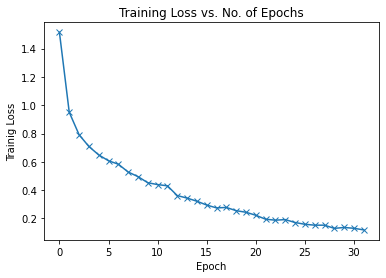

In [134]:
def plot_train_loss(history):
    accuracies = [x['train_loss'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Trainig Loss')
    plt.title('Training Loss vs. No. of Epochs');

plot_train_loss(history)

#### Validation Loss Graph

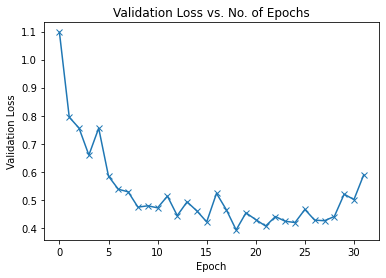

In [135]:
def plot_val_loss(history):
    accuracies = [x['val_loss'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. No. of Epochs');

plot_val_loss(history)

#### Validation Accuracy Graph

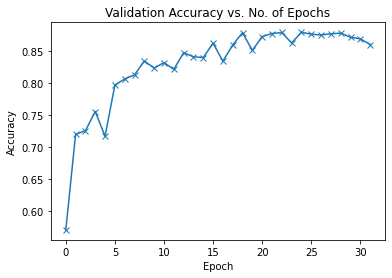

In [136]:
def plot_val_accuracy(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. No. of Epochs');

plot_val_accuracy(history)

#### Confusion Matrix for the Prediction with Best Model

In [137]:
true_test_labels = []
for itr in range(len_testset):
    true_test_labels.append(test_set[itr][1])

In [138]:
file = open('logs_cnn/pred.csv', 'w')
evaluate(model_2, test_dl, file)
file.close()

In [139]:
import re
predicted_test_labels = []
p_file = open('logs_cnn/pred.csv', 'r')
p_formatted = open('logs_cnn/submission', 'w')
p_formatted.write(f"id,label\n")
lines = p_file.readlines()
count = 0
for line in lines:
    s1, s2 = line.split(',')
    s2 = re.sub('tensor', '', s2)
    s2 = re.sub('\(', '', s2)
    s2 = re.sub('\)', '', s2)
    s2 = re.sub('\'', '', s2)
    s2 = re.sub('\\n', '', s2)
    predicted_test_labels.append(int(s2))
    entry = str(count) + "," + str(s2)
    p_formatted.write(f"{count},{s2}\n")
    count += 1
p_file.close()
p_formatted.close()
#print(predicted_test_labels)

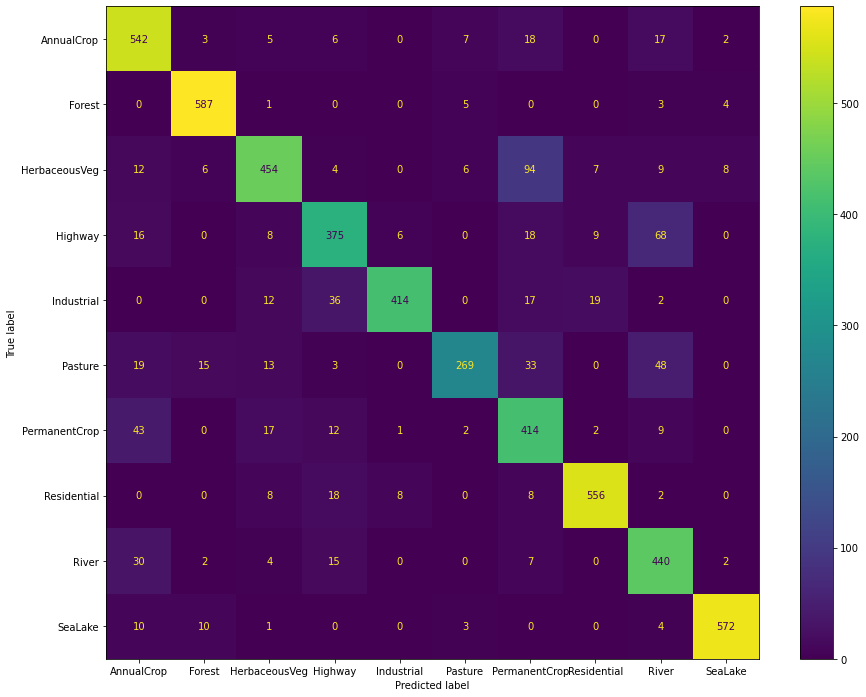

In [145]:
y_true = np.array(true_test_labels)
y_pred = np.array(predicted_test_labels)
cm = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=dataset_classes)
fig, ax = plt.subplots(figsize=(15,12))
cmp.plot(ax=ax)

#### Calculating Recall Scores

In [147]:
recall_scores = recall_score(true_test_labels, predicted_test_labels, average=None)
recall_scores

array([0.90333333, 0.97833333, 0.75666667, 0.75      , 0.828     ,
       0.6725    , 0.828     , 0.92666667, 0.88      , 0.95333333])

In [148]:
recall_scores_np = np.asarray(recall_scores)
recall_scores_np

array([0.90333333, 0.97833333, 0.75666667, 0.75      , 0.828     ,
       0.6725    , 0.828     , 0.92666667, 0.88      , 0.95333333])

In [151]:
print(f'Class\t\tRecall Value')
for itr in range(10):
  print ("{:<15} {:<15}".format( dataset_classes[itr], recall_scores[itr]))

Class		Recall Value
AnnualCrop      0.9033333333333333
Forest          0.9783333333333334
HerbaceousVeg   0.7566666666666667
Highway         0.75           
Industrial      0.828          
Pasture         0.6725         
PermanentCrop   0.828          
Residential     0.9266666666666666
River           0.88           
SeaLake         0.9533333333333334


In [149]:
most_confident = np.argmax(recall_scores_np, axis=0)
most_confident

1

### End